In [3]:
#hide
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila


In [1]:
import pandas as pd
import numpy as np

In [2]:
import xgboost as xgb
import pickle as pic

In [3]:
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score, recall_score
#from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, PrecisionRecallCurve
from lightgbm import LGBMClassifier
from sklearn import datasets

In [4]:
df=pd.read_csv('ssd_raw_rul.csv').drop(columns=['cycle'])

In [5]:
df.shape

(2517, 20)

In [6]:
df['target'] = np.where(df['RUL']<=30,1,0)

In [7]:
df.drop(columns=['RUL'],inplace=True)

In [8]:
test_serial=['NB1208TA', '7LZ021NC', '7LZ022BP', 'S35UNX0J104426B', 'S35UNX0J104414Y', 'S35UNX0J105329E' ]

In [9]:
df_train=df[~df['serial_number'].isin(test_serial)]

In [10]:
df_test=df[df['serial_number'].isin(test_serial)]

In [11]:
df_train.target.mean()

0.17139408569704284

In [12]:
df_test.target.mean()

0.1941860465116279

In [13]:
df_test.head()

,serial_number,smart_1_raw,smart_5_raw,smart_9_raw_x,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_190_raw,smart_192_raw,smart_194_raw,smart_195_raw,smart_196_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_241_raw,smart_242_raw,target
293,7LZ021NC,0.0,NaN,206,4,NaN,NaN,NaN,NaN,NaN,1.0,39.0,NaN,NaN,NaN,NaN,NaN,333,7.0,0
294,7LZ021NC,0.0,NaN,230,4,NaN,NaN,NaN,NaN,NaN,1.0,38.0,NaN,NaN,NaN,NaN,NaN,448,7.0,0
295,7LZ021NC,0.0,NaN,254,4,NaN,NaN,NaN,NaN,NaN,1.0,36.0,NaN,NaN,NaN,NaN,NaN,559,8.0,0
296,7LZ021NC,0.0,NaN,279,4,NaN,NaN,NaN,NaN,NaN,1.0,35.0,NaN,NaN,NaN,NaN,NaN,676,8.0,0
297,7LZ021NC,0.0,NaN,302,4,NaN,NaN,NaN,NaN,NaN,1.0,32.0,NaN,NaN,NaN,NaN,NaN,787,8.0,0


In [14]:
def drop_missings(df, thresh=0.9):
    percent_missing = df.isnull().sum() / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})

    return missing_value_df[percent_missing<=thresh]['column_name'].tolist()
# drop_missings(df_train)

In [15]:
def correlation(dataset, threshold=0.1):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [16]:
def fill_missings(df_first,df_second):
    return df_first.fillna(df_second.median())

In [17]:
train_columns = drop_missings(df_train)

In [18]:
df_train_noncor_columns = sorted(correlation(df_train[train_columns]))


In [19]:
df_train_preprocessed = fill_missings(df_train[df_train_noncor_columns],df_train[df_train_noncor_columns])

In [20]:
df_test_preprocessed = fill_missings(df_test[df_train_noncor_columns],df_train[df_train_noncor_columns])

In [21]:
from xgboost import XGBClassifier

In [22]:
X_train=df_train_preprocessed.drop('target', axis=1)

In [23]:
X_test=df_test_preprocessed.drop('target', axis=1)

In [24]:
y_train=df_train_preprocessed['target']

In [25]:
y_test=df_test_preprocessed['target']

In [26]:
def micro_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, average='micro')

In [27]:
X_train.head()

,smart_12_raw,smart_192_raw,smart_194_raw,smart_241_raw,smart_242_raw
0,5,3.0,34.0,733,9.0
1,5,3.0,29.0,834,9.0
2,5,3.0,27.0,924,9.0
3,5,3.0,32.0,987,9.0
4,5,3.0,27.0,1118,9.0


In [28]:
numerical_features = X_train.columns.tolist()

In [29]:
def create_new_model():
    model = make_pipeline(StandardScaler(), LogisticRegression(random_state=77, n_jobs=-1, solver='saga'))
    return model

In [30]:
model = create_new_model()

In [31]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=numerical_features,
                             number_of_candidate_features=2, number_of_interacting_features=5,
                             evaluation_metric=micro_recall_score, minimize_metric=False, enable_weights=True,
                             n_jobs=62, cross_validation_in_objective_func=True, objective_func_cv=3)

2021-03-13 08:08:23,811:INFO: New Engineer created with the following parameters: 
2021-03-13 08:08:23,813:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['smart_12_raw', 'smart_192_raw', 'smart_194_raw', 'smart_241_raw', 'smart_242_raw']
Number of candidate features: 2
Number of interacting features: 5
Evaluation Metric: micro_recall_score
Minimize metric is False 


In [32]:
gfe.fit(mu=5, lambda_=100, early_stopping_patience=4, mutation_probability=0.4, crossover_probability=0.6)

Start of evolution
   	      	                                                            fitness                                                            
   	      	-------------------------------------------------------------------------------------------------------------------------------
gen	nevals	avg     	best_val_score	gen	gen_val_score	max     	min     	nevals	std      	time_in_seconds
0  	5     	0.818198	nan           	0  	nan          	0.870248	0.687275	5     	0.0719787	nan            
1  	100   	0.871092	0.893961      	1  	0.893961     	0.874467	0.870248	100   	0.00168776	4.45781        
2  	100   	0.874467	0.893961      	2  	0.881322     	0.874467	0.874467	100   	1.11022e-16	1.87923        
3  	100   	0.874467	0.893961      	3  	0.881322     	0.874467	0.874467	100   	1.11022e-16	2.17291        
4  	100   	0.874467	0.893961      	4  	0.881322     	0.874467	0.874467	100   	1.11022e-16	2.02259        
-- End of (successful) evolution --
Best validation score: 0.89396129974

In [34]:
new_X_train = gfe.transform(X_train)
new_X_test = gfe.transform(X_test)

In [37]:
df_train.head()

,smart_12_raw,smart_192_raw,smart_194_raw,smart_241_raw,smart_242_raw,0.5*smart_12_raw - 0.99*smart_242_raw,-1.04*smart_192_raw + 0.67*smart_241_raw,target
0,5,3.0,34.0,733,9.0,-6.41,487.99,0
1,5,3.0,29.0,834,9.0,-6.41,555.66,0
2,5,3.0,27.0,924,9.0,-6.41,615.96,0
3,5,3.0,32.0,987,9.0,-6.41,658.17,0
4,5,3.0,27.0,1118,9.0,-6.41,745.94,0


In [35]:
df_train=pd.merge(new_X_train, y_train, right_index=True, left_index=True)

In [36]:
df_test=pd.merge(new_X_test, y_test, right_index=True, left_index=True)

In [ ]:
df_train.to_csv('preprocessed_training.csv')

In [ ]:
df_test.to_csv('preprocessed_testing.csv')

XGBClassifier(Lambda=1.0, alpha=1.0, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6257870129287602, colsample_bynode=1,
              colsample_bytree=1.0, eta=0.3598670326139477,
              eval_metric='logloss', gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.359867036, max_delta_step=0, max_depth=8,
              min_child_weight=1.0, missing=None, monotone_constraints='()',
              n_estimators=81, n_jobs=8, num_parallel_tree=1, random_state=55,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
{"eta": 0.4239918665490173	 "max_depth": 9	 "gamma": 0.0	 "min_child_weight": 0.6718580108570116	 "subsample": 1.0	 "colsample_bytree": 1.0	 "colsample_bylevel": 1.0	 "lambda": 0.8252195466502932	 "alpha": 0.4637029911175976	 "n_estimators": 9}


In [41]:
model = XGBClassifier(alpha=1.0, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6257870129287602, colsample_bynode=1,
              colsample_bytree=1.0, eta=0.3598670326139477,
              eval_metric='logloss', gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='', Lambda=1.0,
              learning_rate=0.359867036, max_delta_step=0, max_depth=8,
              min_child_weight=1.0, missing=None, monotone_constraints='()',
              n_estimators=81, n_jobs=8, num_parallel_tree=1, random_state=55,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
model.fit(new_X_train, y_train)

[08:44:01] WARNING: ../src/learner.cc:541: 
Parameters: { Lambda } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(Lambda=1.0, alpha=1.0, base_score=0.5, booster='gbtree',
              colsample_bylevel=0.6257870129287602, colsample_bynode=1,
              colsample_bytree=1.0, eta=0.3598670326139477,
              eval_metric='logloss', gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.359867036, max_delta_step=0, max_depth=8,
              min_child_weight=1.0, missing=None, monotone_constraints='()',
              n_estimators=81, n_jobs=8, num_parallel_tree=1, random_state=55,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [43]:
#y_pred = model.predict(new_X_test)

In [53]:
y_pred = model.predict(new_X_test)
probas_pred = model.predict_proba(new_X_test)

In [44]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [54]:
print("recall: ", recall_score(y_test, y_pred))
print("precision: ",precision_score(y_test, y_pred))
print("f1: ",f1_score(y_test,y_pred))
print("conf matrix: \n",confusion_matrix(y_test,y_pred))

recall:  0.8023952095808383
precision:  0.8993288590604027
f1:  0.8481012658227848
conf matrix: 
 [[678  15]
 [ 33 134]]


In [58]:
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, precision_recall_fscore_support, classification_report, average_precision_score, precision_recall_curve, PrecisionRecallDisplay, RocCurveDisplay,roc_auc_score, roc_curve
from sklearn.metrics import make_scorer as score
import matplotlib.pyplot as plt

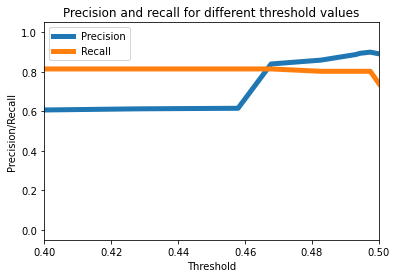

In [65]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_test, probas_pred[:,1])
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xlim((0.4,0.5))
plt.legend()
plt.show()

In [96]:
threshold_rt[24]

0.46777534

In [94]:
thresh = threshold_rt[np.argmin(abs(precision_rt[1:] - recall_rt[1:]))]
thresh_preds = np.where(probas_pred[:,1]<=thresh,0,1)
tn,fp,fn,tp = confusion_matrix(y_test,thresh_preds).ravel()
specificity = tn/(tn+fp)
sensitivity = tp / (tp + fn)

In [95]:
print("recall: ", recall_score(y_test,thresh_preds))
print("precision: ",precision_score(y_test, thresh_preds))
print("f1: ",f1_score(y_test,thresh_preds))
print("specificity: ",specificity)
print("sensitivity: ",sensitivity)

print("conf matrix: \n",confusion_matrix(y_test,thresh_preds))

recall:  0.8143712574850299
precision:  0.8395061728395061
f1:  0.8267477203647415
specificity:  0.9624819624819625
sensitivity:  0.8143712574850299
conf matrix: 
 [[667  26]
 [ 31 136]]
